Category to Name

In [158]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('dataRNN/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    # print(f"category {category}")
    lines = readLines(filename)
    # print(f"lines {lines}")
    category_lines[category] = lines

n_categories = len(all_categories)
# temp = category_lines['Arabic']
# temp = list(set(temp))
# print(temp)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))
print(category_lines)

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal
{'Czech': ['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch', 'Antonowitz', 'Bacon', 'Ballalatak', 'Ballaltick', 'Bartonova', 'Bastl', 'Baroch', 'Benesch', 'Betlach', 'Biganska', 'Bilek', 'Blahut', 'Blazek', 'Blazek', 'Blazejovsky', 'Blecha', 'Bleskan', 'Blober', 'Bock', 'Bohac', 'Bohunovsky', 'Bolcar', 'Borovka', 'Borovski', 'Borowski', 'Borovsky', 'Brabbery', 'Brezovjak', 'Brousil', 'Bruckner', 'Buchta', 'Cablikova', 'Camfrlova', 'Cap', 'Cerda', 'Cermak', 'Chermak', 'Cermak', 'Cernochova', 'Cernohous', 'Cerny', 'Cerney', 'Cerny', 'Cerv', 'Cervenka', 'Chalupka', 'Charlott', 'Chemlik', 'Chicken', 'Chilar', 'Chromy', 'Cihak', 'Clineburg', 'Klineberg', 'Cober', 'Colling', 'Cvacek', 'Czabal', 'Damell', 'Demall', 'Dehmel', 'Dana', 'Dejmal', 'Dempko', 'Demko', 'Dinko', 'Divoky',

In [159]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [160]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    # print(f"line and category {line} {category}")
    return category, line

# print(randomTrainingPair())

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    # print(li)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor
# print(categoryTensor("English").shape)

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    # print(tensor.shape)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# print(inputTensor("and"))

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# print(targetTensor("abc"))


# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor


In [161]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [162]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [163]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 4s (5000 5%) 2.3939
0m 9s (10000 10%) 2.9215
0m 14s (15000 15%) 2.3995
0m 19s (20000 20%) 3.0067
0m 24s (25000 25%) 2.6063
0m 29s (30000 30%) 2.3658
0m 33s (35000 35%) 2.0993
0m 38s (40000 40%) 2.2765
0m 43s (45000 45%) 1.7914
0m 48s (50000 50%) 2.4465
0m 53s (55000 55%) 3.1402
0m 58s (60000 60%) 3.1170
1m 3s (65000 65%) 1.6879
1m 7s (70000 70%) 2.7837
1m 12s (75000 75%) 2.0967
1m 17s (80000 80%) 2.4059
1m 22s (85000 85%) 2.6469
1m 27s (90000 90%) 2.6466
1m 32s (95000 95%) 1.5560
1m 36s (100000 100%) 1.6697


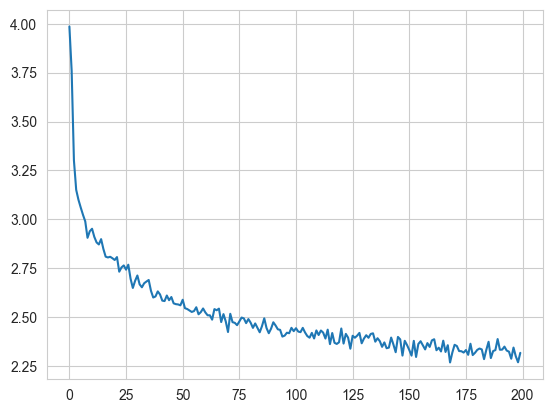

In [164]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [165]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

print("_____")

samples('German', 'GER')
print("_____")

samples('Spanish', 'SPA')
print("_____")

samples('Chinese', 'CHI')
print("_____")

Rovellov
Uarinov
Sharinov
_____
Gerter
Erenter
Rosher
_____
Sallanoz
Paner
Arana
_____
Chan
Han
Iun
_____
